# Qiskit Tutorial Notebook

Qiskit is an open-source Python library for quantum computing. It can be used to create and analyze quantum circuits, or programs. 
Qiskit Aer is a quantum circuit simulation framework written in Qiskit. Qiskit Runtime provides an interface between quantum programs and quantum hardware, allowing for the execution of circuits on real quantum machines.

In this notebook, we will learn the basics of Qiskit. We will review how to build circuits, run an ideal simulation, and execute an experiment on a quantum computer (QC). To run this notebook, please [follow these instructions](https://docs.quantum.ibm.com/start/install) in the Qiskit documentation to install `qiskit`, `qiskit-ibm-runtime`, and `jupyter`. In addition, please install `qiskit-aer` following the instructions [here](https://github.com/Qiskit/qiskit-aer). To interact with IBM QCs, please make an [IBM Quantum account](https://www.ibm.com/quantum).

In [1]:
import qiskit

# 1. Building and Studying Circuits

We will start by creating a quantum register that holds quantum circuit data and a classical register that holds quantum circuit measurement outcomes. We will create a `QuantumCircuit` using these two objects. 

In [2]:
q_reg = qiskit.QuantumRegister(2, "q_reg")
c_reg = qiskit.ClassicalRegister(2, "c_reg")

circ = qiskit.QuantumCircuit(q_reg, c_reg)
circ.draw(fold=-1)

q_reg_0: 
         
q_reg_1: 
         
c_reg: 2/

Right now, our circuit doesn't hold any information, but we can add some operations. Qiskit out of the box supports many operators, like the controlled-X (CX) gate: 

In [3]:
circ.cx(0, 1)
circ.draw(fold=-1)

q_reg_0: ──■──
         ┌─┴─┐
q_reg_1: ┤ X ├
         └───┘
c_reg: 2/═════

Using `quantum_info.Operator`, we can study the matrix associated with the quantum circuit. Take note that the CX matrix is `flipped' compared to how we are used to seeing it in quantum computing references. This is because of the default qubit ordering used by Qiskit (q1,q0).

In [4]:
qiskit.quantum_info.Operator(circ)

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


Using `reverse_bits()` can help when studying quantum circuits:

In [5]:
qiskit.quantum_info.Operator(circ.reverse_bits())

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


Custom operations can easily be added to a quantum circuit. Let's add an open (i.e. activated by |0>) CX gate:

In [6]:
from qiskit.quantum_info.operators import Operator

circ = qiskit.QuantumCircuit(q_reg, c_reg)
open_cx = Operator([[0, 0, 1, 0],
                   [0, 1, 0, 0],
                   [1, 0, 0, 0],
                   [0, 0, 0, 1]])

circ.unitary(open_cx, [0, 1], label="open_cx")
circ.draw(fold=-1)

┌──────────┐
q_reg_0: ┤0         ├
         │  open_cx │
q_reg_1: ┤1         ├
         └──────────┘
c_reg: 2/════════════

Now let's check if the operation functionality is as expected. We will build a circuit that includes X gates around the control of a CX operation for comparision:

In [7]:
check_circ = qiskit.QuantumCircuit(q_reg, c_reg)
check_circ.x(0)
check_circ.cx(0, 1)
check_circ.x(0)
check_circ.draw(fold=-1)

┌───┐     ┌───┐
q_reg_0: ┤ X ├──■──┤ X ├
         └───┘┌─┴─┐└───┘
q_reg_1: ─────┤ X ├─────
              └───┘     
c_reg: 2/═══════════════

In [8]:
op1 = qiskit.quantum_info.Operator(circ)
op2 = qiskit.quantum_info.Operator(check_circ)

op1.data == op2.data

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

Qiskit allows many ways for a user to modify a circuit. Let's first create a [Bell State](https://en.wikipedia.org/wiki/Bell_state) Generator (BSG) circuit and then use `transpile` to express the circuit using the gate set SX, X, RZ, CZ:

In [9]:
bsg = qiskit.QuantumCircuit(q_reg, c_reg)
bsg.h(0)
bsg.cx(0, 1)
bsg.draw(fold=-1)

┌───┐     
q_reg_0: ┤ H ├──■──
         └───┘┌─┴─┐
q_reg_1: ─────┤ X ├
              └───┘
c_reg: 2/══════════

In [10]:
basis_gates = ["sx", "x", "rz", "cz"]

new_bsg = qiskit.transpile(bsg, basis_gates=basis_gates)

new_bsg.draw(fold=-1)

global phase: 3π/4
         ┌─────────┐┌────┐┌─────────┐                               
q_reg_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─────────────────────────────
         ├─────────┤├────┤├─────────┤ │ ┌─────────┐┌────┐┌─────────┐
q_reg_1: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├
         └─────────┘└────┘└─────────┘   └─────────┘└────┘└─────────┘
c_reg: 2/═══════════════════════════════════════════════════════════

# 2. Ideal Circuit Simulation
Here, we will simulate our Bell State Generator Circuits that we created in the last section and compare their outcomes. First, we need to add measurements to both circuits:

In [11]:
bsg.measure(q_reg, c_reg)
bsg.draw(fold=-1)

┌───┐     ┌─┐   
q_reg_0: ┤ H ├──■──┤M├───
         └───┘┌─┴─┐└╥┘┌─┐
q_reg_1: ─────┤ X ├─╫─┤M├
              └───┘ ║ └╥┘
c_reg: 2/═══════════╩══╩═
                    0  1

In [12]:
new_bsg.measure(q_reg, c_reg)
new_bsg.draw(fold=-1)

global phase: 3π/4
         ┌─────────┐┌────┐┌─────────┐              ┌─┐                    
q_reg_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■────────────┤M├────────────────────
         ├─────────┤├────┤├─────────┤ │ ┌─────────┐└╥┘┌────┐┌─────────┐┌─┐
q_reg_1: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├─╫─┤ √X ├┤ Rz(π/2) ├┤M├
         └─────────┘└────┘└─────────┘   └─────────┘ ║ └────┘└─────────┘└╥┘
c_reg: 2/═══════════════════════════════════════════╩═══════════════════╩═
                                                    0                   1

Now we will use Qiskit Aer to simulate the circuits with 1000 shots. We will plot the corresponding output distributions. While there is some shot noise, we find that both distributions are very similar!

In [13]:
import qiskit_aer
from qiskit.visualization import plot_histogram

sim_ideal = qiskit_aer.AerSimulator()

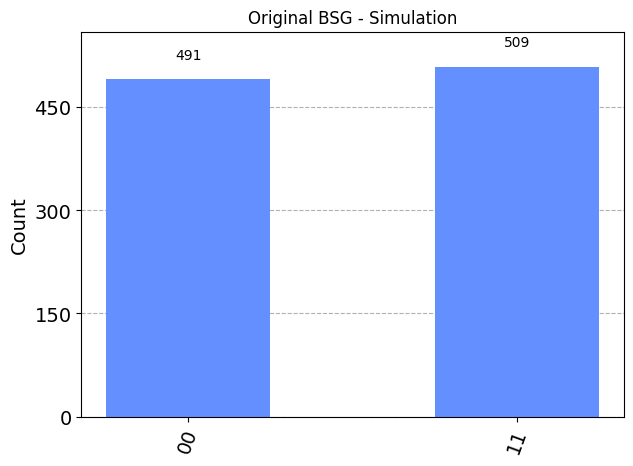

In [14]:
sim_bsg = sim_ideal.run(bsg, shots=1000)
plot_histogram(sim_bsg.result().get_counts(), title="Original BSG - Simulation")

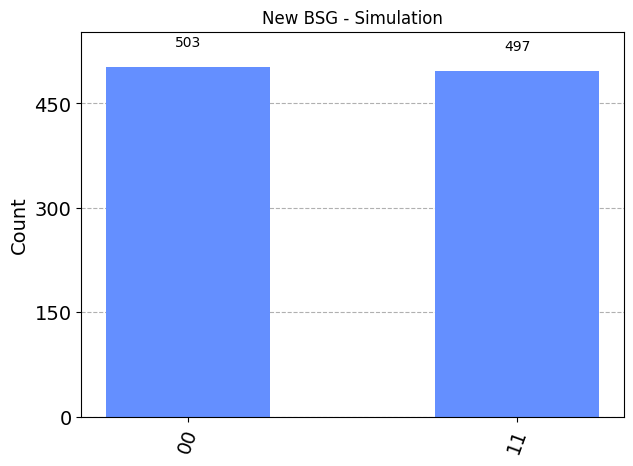

In [15]:
sim_new_bsg = sim_ideal.run(new_bsg, shots=1000)
plot_histogram(sim_new_bsg.result().get_counts(), title="New BSG - Simulation")

## 3. Interacting with Quantum Machines

Here, we will use a Runtime Service to interact with IBM quantum hardware. To access backends, we must use our IBM Quantum API Key.

In [16]:
import qiskit_ibm_runtime
from qiskit_ibm_runtime import QiskitRuntimeService

token = os.environ["IBMQ_API_KEY"]

QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")

You can examine what backends, classical simulators, and quantum hardware, are available for use:

In [17]:
service.backends()

[<IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>]

Let's choose IBM Osaka as our target QC:

In [18]:
ibmq_osaka = service.get_backend("ibm_osaka")

We can learn more about the target backend (qubit error, gate durations, qubit connectivity, etc.) by examining the QC's `properties()` and `configuration()`. Let's look at the gate set associated with this machine:

In [19]:
ibmq_osaka.configuration().basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

These gates are different from those used in our circuits above. Before we can run our circuits on the QC, we must `transpile` using the backend information so that they are compatable with the hardware:

In [20]:
transpiled_bsg = qiskit.transpile(bsg, ibmq_osaka, optimization_level=0)
transpiled_bsg.draw(fold=-1, idle_wires=False)

global phase: 3π/4
             ┌─────────┐   ┌────┐  ┌─────────┐┌──────────┐┌─────────┐   ┌────┐   ┌──────────┐           ┌──────┐┌─────────┐┌────┐┌─────────┐┌───┐┌─┐
q_reg_0 -> 0 ┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├┤ Rz(-π/2) ├┤ Rz(π/2) ├───┤ √X ├───┤ Rz(-π/2) ├───────────┤1     ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ X ├┤M├
             ├─────────┤┌──┴────┴─┐└──┬────┬─┘├─────────┬┘├─────────┤┌──┴────┴──┐└──┬────┬──┘┌─────────┐│  Ecr │├─────────┤├────┤├─────────┤└┬─┬┘└╥┘
q_reg_1 -> 1 ┤ Rz(π/2) ├┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├─┤ Rz(π/2) ├┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π/2) ├┤0     ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤M├──╫─
             └─────────┘└─────────┘   └────┘  └─────────┘ └─────────┘└──────────┘   └────┘   └─────────┘└──────┘└─────────┘└────┘└─────────┘ └╥┘  ║ 
    c_reg: 2/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═══╩═
                                                                                                                                              1   0

In [21]:
transpiled_new_bsg = qiskit.transpile(new_bsg, ibmq_osaka, optimization_level=0)
transpiled_new_bsg.draw(fold=-1, idle_wires=False)

global phase: 7π/4
             ┌─────────┐┌────┐┌─────────┐┌──────────┐┌─────────┐   ┌────┐  ┌──────────┐                                                                    ┌──────┐┌─────────┐┌────┐┌─────────┐   ┌───┐         ┌─┐                                          
q_reg_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-π/2) ├┤ Rz(π/2) ├───┤ √X ├──┤ Rz(-π/2) ├────────────────────────────────────────────────────────────────────┤1     ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├───┤ X ├─────────┤M├──────────────────────────────────────────
             ├─────────┤├────┤├─────────┤├─────────┬┘└──┬────┬─┘┌──┴────┴─┐├─────────┬┘┌─────────┐┌────┐┌─────────┐┌─────────┐┌──────────┐┌────┐┌─────────┐│  Ecr │├─────────┤├────┤├─────────┤┌──┴───┴──┐┌────┐└╥┘┌─────────┐┌─────────┐┌────┐┌─────────┐┌─┐
q_reg_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├────┤ √X ├──┤ Rz(π/2) ├┤ Rz(π/2) ├─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├┤0     ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├─╫─┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤M├
             └─────────┘└────┘└─────────┘└─────────┘    └────┘  └─────────┘└─────────┘ └─────────┘└────┘└─────────┘└─────────┘└──────────┘└────┘└─────────┘└──────┘└─────────┘└────┘└─────────┘└─────────┘└────┘ ║ └─────────┘└─────────┘└────┘└─────────┘└╥┘
    c_reg: 2/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═════════════════════════════════════════╩═
                                                                                                                                                                                                                 0                                         1

Now let's run an experiment using our Bell Stat Generator circuits!

In [22]:
options = qiskit_ibm_runtime.Options(optimization_level=0)
sampler = qiskit_ibm_runtime.Sampler(backend=ibmq_osaka, options=options)

In [23]:
job = sampler.run([transpiled_bsg, transpiled_new_bsg], shots=1000)

In [24]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

Finally, we examine the results:

In [25]:
result = job.result()

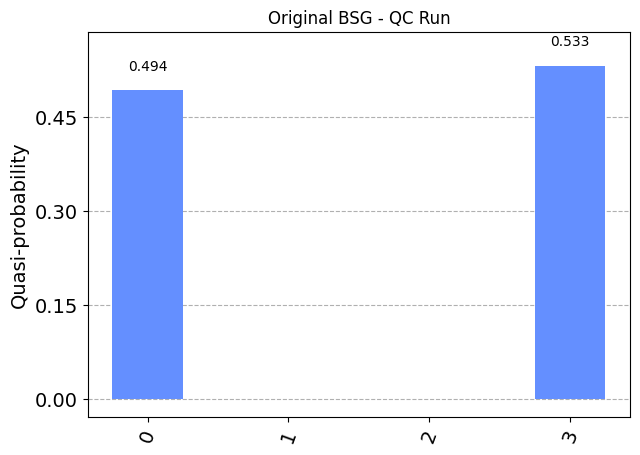

In [26]:
plot_histogram(result.quasi_dists[0], title="Original BSG - QC Run")

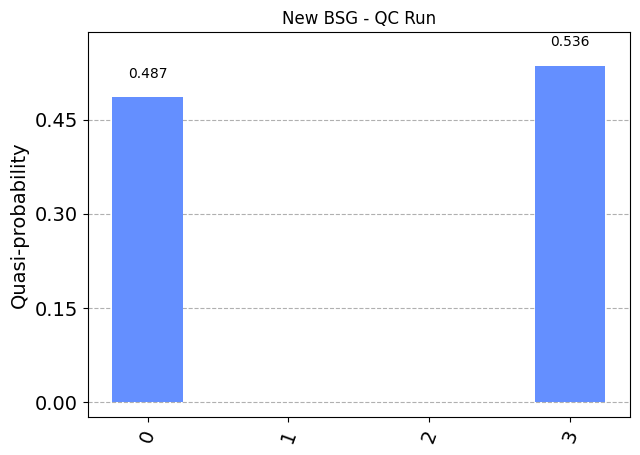

In [27]:
plot_histogram(result.quasi_dists[1], title="New BSG - QC Run")